In [269]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ai-201-b-ese-aiml-a/sample_submission.csv
/kaggle/input/ai-201-b-ese-aiml-a/train.csv
/kaggle/input/ai-201-b-ese-aiml-a/test.csv


In [270]:
#importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    accuracy_score,
    log_loss,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss
from sklearn.calibration import CalibratedClassifierCV

In [271]:
#loading train data
df = pd.read_csv("/kaggle/input/ai-201-b-ese-aiml-a/train.csv")
df["Room_bin"] = df["Room_Occupancy_Count"].map({0.0:0, 1.0:1 , 2.0: 2, 3.0: 3})

print(df.describe())
print(df.info())

X = df.drop(["Room_Occupancy_Count", "Room_bin"], axis=1)
y = df["Room_bin"]

print(X.head())
print(y.head())

           S1_Temp      S2_Temp      S3_Temp      S4_Temp     S1_Light  \
count  7342.000000  7428.000000  7722.000000  7714.000000  7763.000000   
mean     25.449885    25.552375    25.051485    25.753028    25.079367   
std       0.358143     0.609369     0.438819     0.385300    50.988025   
min      23.618230    23.053774    22.454391    23.389567   -31.116547   
25%      25.190000    25.190000    24.690000    25.440000     0.000000   
50%      25.380000    25.380000    24.940000    25.750000     0.000000   
75%      25.630000    25.630000    25.380000    26.000000    11.000000   
max      27.634521    29.000000    26.925609    28.240433   538.337289   

          S2_Light     S3_Light     S4_Light     S1_Sound     S2_Sound  \
count  7256.000000  7420.000000  7332.000000  7792.000000  7139.000000   
mean     25.283882    34.580891    13.151244     0.164250     0.115113   
std      66.846214    60.048976    20.419003     0.310251     0.268127   
min     -35.452461  -296.357071  -100

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


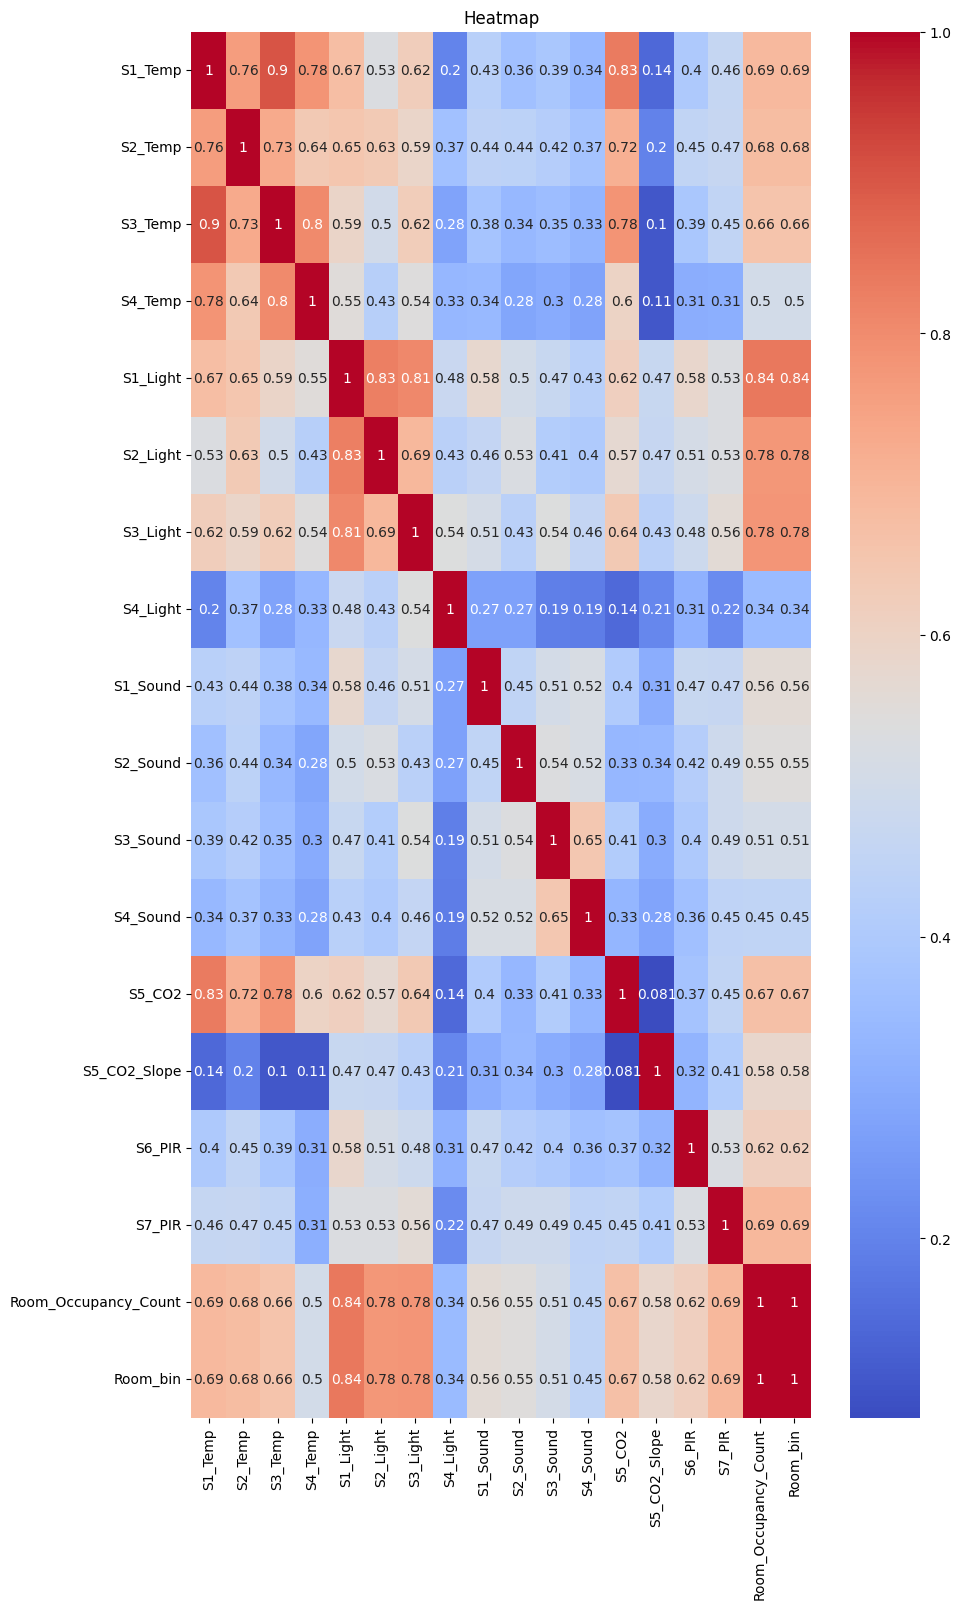

In [272]:
plt.figure(figsize=(10,18))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Heatmap")
plt.show()

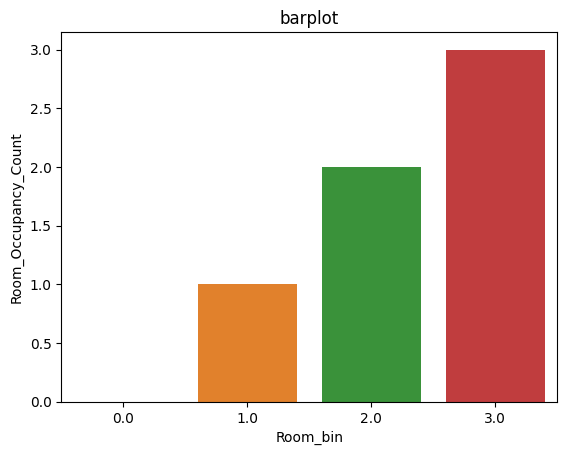

In [273]:
sns.barplot(
    data=df,
    x=y,
    y="Room_Occupancy_Count",
    estimator="mean",
    errorbar=None
           )

plt.title("barplot")
plt.show()

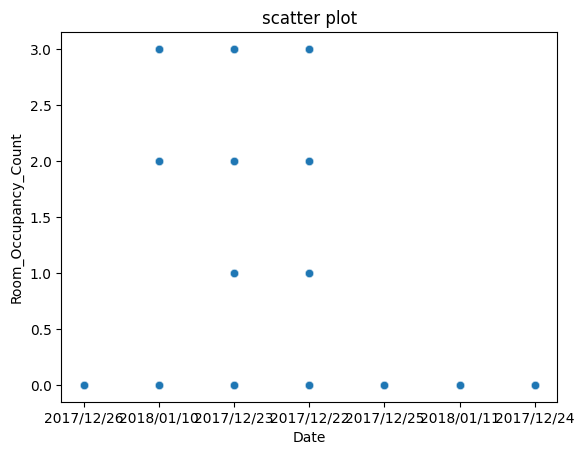

In [274]:
sns.scatterplot(
    data=df,
    x="Date",
    y="Room_Occupancy_Count",
    alpha=0.6
)

plt.title("scatter plot")
plt.show()

In [275]:
#Encoding Categorical Columns
cat_cols = X.select_dtypes(include=["object"]).columns


oe = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X[cat_cols] = oe.fit_transform(X[cat_cols].astype(str))



In [276]:
#Filling Null Values
X = X.fillna(X.median(numeric_only=True))
y = y.fillna(y.median(numeric_only=True))



In [277]:
#Handling Outliers
def cap_outliers(df, cols, lower=1, upper=99):
    for col in cols:
        low_val = df[col].quantile(lower / 100)
        high_val = df[col].quantile(upper / 100)
        df[col] = df[col].clip(low_val, high_val)
    return df

num_cols = X.select_dtypes(include=['float64', 'int64']).columns
X = cap_outliers(X, num_cols)

print(X.head())
print(y.head())

   Date    Time  S1_Temp  S2_Temp  S3_Temp  S4_Temp  S1_Light   S2_Light  \
0   7.0  1928.0    25.06    25.06    24.44    25.31       0.0   0.000000   
1   4.0  1611.0    25.19    25.25    24.94    25.56       0.0   0.000000   
2   7.0  3619.0    25.88    26.94    25.56    26.31      14.0  15.000000   
3   7.0  4547.0    25.88    26.13    25.63    25.88       0.0   0.000000   
4   5.0  4540.0    25.88    26.13    25.69    25.94       0.0  35.452461   

   S3_Light  S4_Light  S1_Sound  S2_Sound  S3_Sound  S4_Sound  S5_CO2  \
0       1.0       0.0      0.07      0.05      0.07      0.06   360.0   
1       0.0       0.0      0.07      0.06      0.06      0.10   355.0   
2      72.0      53.0      0.08      0.07      0.06      0.06   585.0   
3       0.0       0.0      0.07      0.04      0.05      0.09   825.0   
4       0.0       0.0      0.07      0.04      0.05      0.09   835.0   

   S5_CO2_Slope  S6_PIR  S7_PIR  
0      0.046154     0.0     0.0  
1      0.000000     0.0     0.0  
2 

In [278]:
#Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [279]:
#Training Model
num_classes = len(np.unique(y_train))

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features='sqrt',
    random_state=42,
    n_jobs=-1
)

#Use calibrated classifier for probabilitiesp
model = CalibratedClassifierCV(base_estimator=rf, method='isotonic', cv=5)
model.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/calibration.py:321: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


CalibratedClassifierCV(base_estimator=RandomForestClassifier(min_samples_leaf=2,
                                                             min_samples_split=5,
                                                             n_estimators=300,
                                                             n_jobs=-1,
                                                             random_state=42),
                       cv=5, method='isotonic')

In [280]:
#measuring performance
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)


y_pred_prob = model.predict_proba(X_test)
log_l = log_loss(y_test, y_pred_prob, labels=model.classes_)


precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# ======== DISPLAY ========
print("Accuracy:", acc)
print("Log Loss:", log_l)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9804996953077392
Log Loss: 0.06269801535703885
Precision: 0.9824280247663993
Recall: 0.9804996953077392
F1 Score: 0.9809739700786785

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99      1359
         1.0       0.86      0.98      0.92        63
         2.0       0.88      0.99      0.93       108
         3.0       0.93      0.98      0.96       111

    accuracy                           0.98      1641
   macro avg       0.92      0.98      0.95      1641
weighted avg       0.98      0.98      0.98      1641



In [281]:
#loading train data
x_test=pd.read_csv("/kaggle/input/ai-201-b-ese-aiml-a/test.csv")
ids=x_test["id"]
x_test=x_test.drop(["id"], axis=1)

cat_cols = x_test.select_dtypes(include=["object"]).columns
x_test[cat_cols] = oe.fit_transform(x_test[cat_cols].astype(str))

x_test=x_test.fillna(x_test.median(numeric_only=True))

num_cols=x_test.select_dtypes(include=["int64", "float64"]).columns

x_test=cap_outliers(x_test, num_cols)


In [282]:
#prediction
y_pred1=model.predict(x_test)

submission = pd.DataFrame({
    "id":ids,
    "Room_Occupancy_Count":y_pred1
})

for i in submission["Room_Occupancy_Count"]:
    i=int(i)

# submission["Room_Occupancy_Count"]=submission["Room_Occupancy_Count"].map({0.0:"zero", 1.0:"one", })
# submission["Room_Occupancy_Count"]=submission["Room_Occupancy_Count"].map({"zero":int(0), "one":int(1)})
# print(y_pred1[1].dtype())

sample=pd.read_csv("/kaggle/input/ai-201-b-ese-aiml-a/sample_submission.csv")
print(sample.head())



#csv generation
print(submission.head())
submission.to_csv("ARSubmission.csv", index=False)

   id  Room_Occupancy_Count
0   1                     0
1   2                     0
2   3                     0
3   4                     0
4   5                     0
   id  Room_Occupancy_Count
0   1                   0.0
1   2                   1.0
2   3                   0.0
3   4                   0.0
4   5                   0.0
